In [131]:
import pandas as pd
import numpy as np
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt

In [132]:
#importing the terms csv data obtained from the internet and creating Dataframe
Germany_interest= pd.DataFrame(pd.read_csv("Germany_interest.csv", header =1))
UK_interest= pd.DataFrame(pd.read_csv("UK_interest.csv", header =1))
USA_interest= pd.DataFrame(pd.read_csv("USA_interest.csv", header =1))

#Note, I had to learn what header was in this

In [133]:
#Cleaning up term datasets 
#drop NA from AI term 

Germany_interest.dropna(inplace=True)

#drop NA from Chat gpt terms
UK_interest.dropna(inplace=True)

#drop NA from USA interest
USA_interest.dropna(inplace=True)

USA_interest.head(5)

,Week,ai: (United States)
0,2020-05-03,5
1,2020-05-10,5
2,2020-05-17,5
3,2020-05-24,5
4,2020-05-31,4


In [134]:
#FIrst 2 table merge
Combined_table  = pd.merge(Germany_interest, UK_interest, left_on='Week', right_on='Week')

#Final merged table
AI_interest= pd.merge(Combined_table, USA_interest, left_on='Week', right_on='Week')
AI_interest['Week']= pd.to_datetime(AI_interest['Week'])
AI_interest.head()




,Week,ai: (Germany),ai: (United Kingdom),ai: (United States)
0,2020-05-03,5,5,5
1,2020-05-10,5,5,5
2,2020-05-17,5,5,5
3,2020-05-24,5,5,5
4,2020-05-31,5,5,4


In [135]:
#Rename columns
AI_interest.rename(columns={'ai: (Germany)':'Germany','ai: (United Kingdom)':'UK','ai: (United States)':'USA', 'Week':'Date'}, inplace=True)



AI_interest.head(10)

,Date,Germany,UK,USA
0,2020-05-03,5,5,5
1,2020-05-10,5,5,5
2,2020-05-17,5,5,5
3,2020-05-24,5,5,5
4,2020-05-31,5,5,4
5,2020-06-07,5,5,5
6,2020-06-14,5,5,5
7,2020-06-21,5,5,5
8,2020-06-28,5,5,4
9,2020-07-05,5,5,5


In [136]:
#Importing ai jobs data

ai_job = pd.DataFrame(pd.read_csv("USA_UK_GERMANY_JOB AI.csv"))
ai_job

,__typename,dateString,countryCode,countryName,value
0,HiringLabNationalAI,2019-01-01,DE,Germany,2.03
1,HiringLabNationalAI,2019-01-01,GB,United Kingdom,2.23
2,HiringLabNationalAI,2019-01-01,US,United States,1.71
3,HiringLabNationalAI,2019-01-02,DE,Germany,2.02
4,HiringLabNationalAI,2019-01-02,GB,United Kingdom,2.23
...,...,...,...,...,...
6841,HiringLabNationalAI,2025-03-30,GB,United Kingdom,3.52
6842,HiringLabNationalAI,2025-03-30,US,United States,2.55
6843,HiringLabNationalAI,2025-03-31,DE,Germany,2.44
6844,HiringLabNationalAI,2025-03-31,GB,United Kingdom,3.52


In [137]:
#dropping columns I don't need

ai_job.drop(columns=['__typename'], inplace=True)


In [138]:
#renaming columns

ai_job.rename(columns={'dateString':'Date', 'value':'percent_of_jobs'}, inplace=True)
final_df = ai_job.groupby('Date').mean(numeric_only=True).reset_index()

final_df.head()

,Date,percent_of_jobs
0,2019-01-01,1.990000
1,2019-01-02,1.986667
2,2019-01-03,1.983333
3,2019-01-04,1.983333
4,2019-01-05,1.973333


In [139]:
#connecting to mySQL
from sqlalchemy import create_engine
# Your MySQL credentials
username = "root"        # e.g. "root"
password = "%Mail1226="        # e.g. "admin123"
host = "localhost"                # or IP address of remote server
port = "3306"                     # default MySQL port
database = "jobs_and_ai"   # e.g. "ai_project"

# Create engine
engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}")

ai_job.to_sql("ai_jobs", con=engine, if_exists="replace", index=False)
AI_interest.to_sql("ai_interest", con=engine, if_exists="replace", index=False)




262

In [ ]:
#-- Does public interest in AI correlate with AI job growth?

#Query from SQL

from numpy import mean


query_1 = """
SELECT 
	DISTINCT i.Date,
    percent_of_jobs,
    Germany,
    UK,
    USA
FROM ai_interest AS i
LEFT JOIN ai_jobs AS j ON j.Date = i.Date 
"""
#run query and store in dataframe
corr_with_interest= pd.read_sql(query_1, con=engine)


#The following was new to me...I need to learn normalizing data


#Normalizing the columns
orig_cols = ['percent_of_jobs', 'Germany', 'USA', 'UK']

#Scaling to 1 by dividing
norm = corr_with_interest[orig_cols].div(corr_with_interest[orig_cols].max(), axis=1)

#renaming normalized columns to avoid confusion
norm.columns = ['Percent_of_jobs_with_AI',
    'Germany_AI_interest',
    'USA_AI_Interest',
    'UK_AI_Interest']
#join normalized data to new dataframe
corr = corr_with_interest.join(norm)

long = corr.melt(
    id_vars='Date',                      
    value_vars= ['Percent_of_jobs_with_AI',
    'Germany_AI_interest',
    'USA_AI_Interest',
    'UK_AI_Interest'],
    var_name='series',
    value_name='value'
)



C:\Users\dgil0\AppData\Local\Temp\ipykernel_25332\2434754796.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax=sns.lineplot(data=long, x='Date', y='value', hue='series', ci=None)


Text(0.5, 1.0, 'AI job growth with and AI interest')

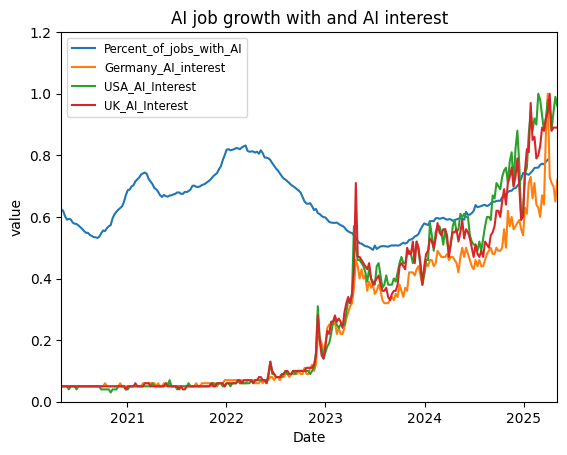

In [ ]:
#Making my graph....I learned that I have to use ax when I'm using seaborn and want to use plt stuff

ax=sns.lineplot(data=long, x='Date', y='value', hue='series', ci=None)
ax.legend(fontsize ='small')
ax.set(ylim=(0, 1.2))  
ax.margins(x=0) # start the y-axis at zero
ax.autoscale_view()  
ax.set_title('AI job growth with and AI interest')
